In [62]:
import geopandas
import geopandas as gpd
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import pandas as pd
from shapely.ops import nearest_points
from shapely.geometry import Point
import pandas as pd
import math
import ast

path='s3://ecb-hackathon-data-group08-x19s00/economic_data/regional_boundaries/'


gdf = geopandas.read_file(path + 'NUTS_RG_20M_2021_3035.shp')
gdf['centroid'] = gdf['geometry'].centroid

gdf_centroids = gdf.copy()
gdf_centroids['geometry'] = gdf['geometry'].centroid

centroids_sindex = gdf_centroids.sindex

gdf = gdf[gdf['LEVL_CODE']==3]

In [12]:
# add NEIGHBORS column

gdf["NEIGHBORS"] = None  
for index, country in gdf.iterrows():   
    # get 'not disjoint' countries
    neighbors = gdf[~gdf.geometry.disjoint(country.geometry)].NUTS_ID.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.NUTS_ID != name ]

    # add names of neighbors as NEIGHBORS value
    gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)


gdf["NEIGHBORS"] = gdf['NEIGHBORS'].str.split(', ')
#gdf["NEIGHBORS_NUTS"]  = gdf.apply(lambda row: row['NEIGHBORS'] + [row['NUTS_ID']], axis=1)

In [13]:
df = pd.read_csv('Benchmark_df.csv')
df = df.merge(gdf[['NEIGHBORS', 'NUTS_ID']], on = ['NUTS_ID'], how = 'left')
df

year NUTS_ID sector  area  employment       gdp      GVA  population  \
0      2002   AT111      A   NaN         1.6    627.48    37.00       37.73   
1      2002   AT111      C   NaN         2.2    627.48    92.00       37.73   
2      2002   AT112      A   NaN         6.0   2849.41   142.00      141.15   
3      2002   AT112      C   NaN         7.0   2849.41   395.00      141.15   
4      2002   AT113      A   NaN         4.8   1721.08    55.00       97.62   
...     ...     ...    ...   ...         ...       ...      ...         ...   
45009  2021   SK032      C   NaN         NaN   8694.03  1838.85      623.25   
45010  2021   SK041      A   NaN         NaN   8985.50   204.57      808.46   
45011  2021   SK041      C   NaN         NaN   8985.50  2012.74      808.46   
45012  2021   SK042      A   NaN         NaN  12042.57   208.22      781.05   
45013  2021   SK042      C   NaN         NaN  12042.57  2835.63      781.05   

       Total_GVA  GVA_share  ...  fapar_min  fapar_low_months  \
0         560.00   0.066071  ...        NaN               NaN   
1         560.00   0.164286  ...        NaN               NaN   
2        2543.00   0.055840  ...        NaN               NaN   
3        2543.00   0.155328  ...        NaN               NaN   
4        1536.00   0.035807  ...        NaN               NaN   
...          ...        ...  ...        ...               ...   
45009    7743.78   0.237462  ...     -1.527               1.0   
45010    8003.39   0.025560  ...     -1.445               1.0   
45011    8003.39   0.251486  ...     -1.445               1.0   
45012   10726.32   0.019412  ...     -1.365               1.0   
45013   10726.32   0.264362  ...     -1.365               1.0   

       fapar_severe_low_months  NN_MEDIAN_spa01  NN_LF_average_a  \
0                          NaN         1.805446         0.127676   
1                          NaN         1.805446         0.127676   
2                          NaN         1.804643         0.123458   
3                          NaN         1.804643         0.123458   
4                          NaN         1.808216         0.132464   
...                        ...              ...              ...   
45009                      0.0              NaN              NaN   
45010                      0.0              NaN              NaN   
45011                      0.0              NaN              NaN   
45012                      0.0              NaN              NaN   
45013                      0.0              NaN              NaN   

       NN_median_intensity  MOUNT_TYPE  URBN_TYPE  COAST_TYPE  \
0                 2.334952         4.0        3.0         3.0   
1                 2.334952         4.0        3.0         3.0   
2                 2.277302         4.0        3.0         3.0   
3                 2.277302         4.0        3.0         3.0   
4                 2.222216         4.0        3.0         3.0   
...                    ...         ...        ...         ...   
45009                  NaN         NaN        NaN         NaN   
45010                  NaN         NaN        NaN         NaN   
45011                  NaN         NaN        NaN         NaN   
45012                  NaN         NaN        NaN         NaN   
45013                  NaN         NaN        NaN         NaN   

                                               NEIGHBORS  
0                    [AT112, AT113, AT122, HU221, HU222]  
1                    [AT112, AT113, AT122, HU221, HU222]  
2                    [AT111, AT122, AT127, SK010, HU221]  
3                    [AT111, AT122, AT127, SK010, HU221]  
4                    [AT111, AT122, AT224, SI031, HU222]  
...                                                  ...  
45009  [SK022, SK023, SK031, HU311, HU313, SK041, SK042]  
45010         [SK031, PL218, PL219, PL821, SK032, SK042]  
45011         [SK031, PL218, PL219, PL821, SK032, SK042]  
45012                       [HU311, HU323, SK032, SK041]  
45013                       [H

In [14]:
var = 'MEDIAN_spa01'
# Function to count occurrences of col2 = 1 in the NEIGHBOR list
def neighbors_agg(row):
    neighbor_list = row['NEIGHBORS']  

    if  (neighbor_list is not np.nan) :
        #neighbor_list = ast.literal_eval(neighbor_list)
        res = df[(df['NUTS_ID'].isin(neighbor_list))][var].mean()
        return res

for var in ['MEDIAN_spa01', 'LF_average_a' , 'median_intensity' ] : # , 
    df['NN_'+var] = df.apply(neighbors_agg, axis=1)


In [15]:
df_final = df[['NUTS_ID', 'year', 'NN_MEDIAN_spa01', 'NN_LF_average_a' , 'NN_median_intensity', 'MOUNT_TYPE' ,'URBN_TYPE', 'COAST_TYPE']].drop_duplicates()

/tmp/ipykernel_16723/1393156257.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


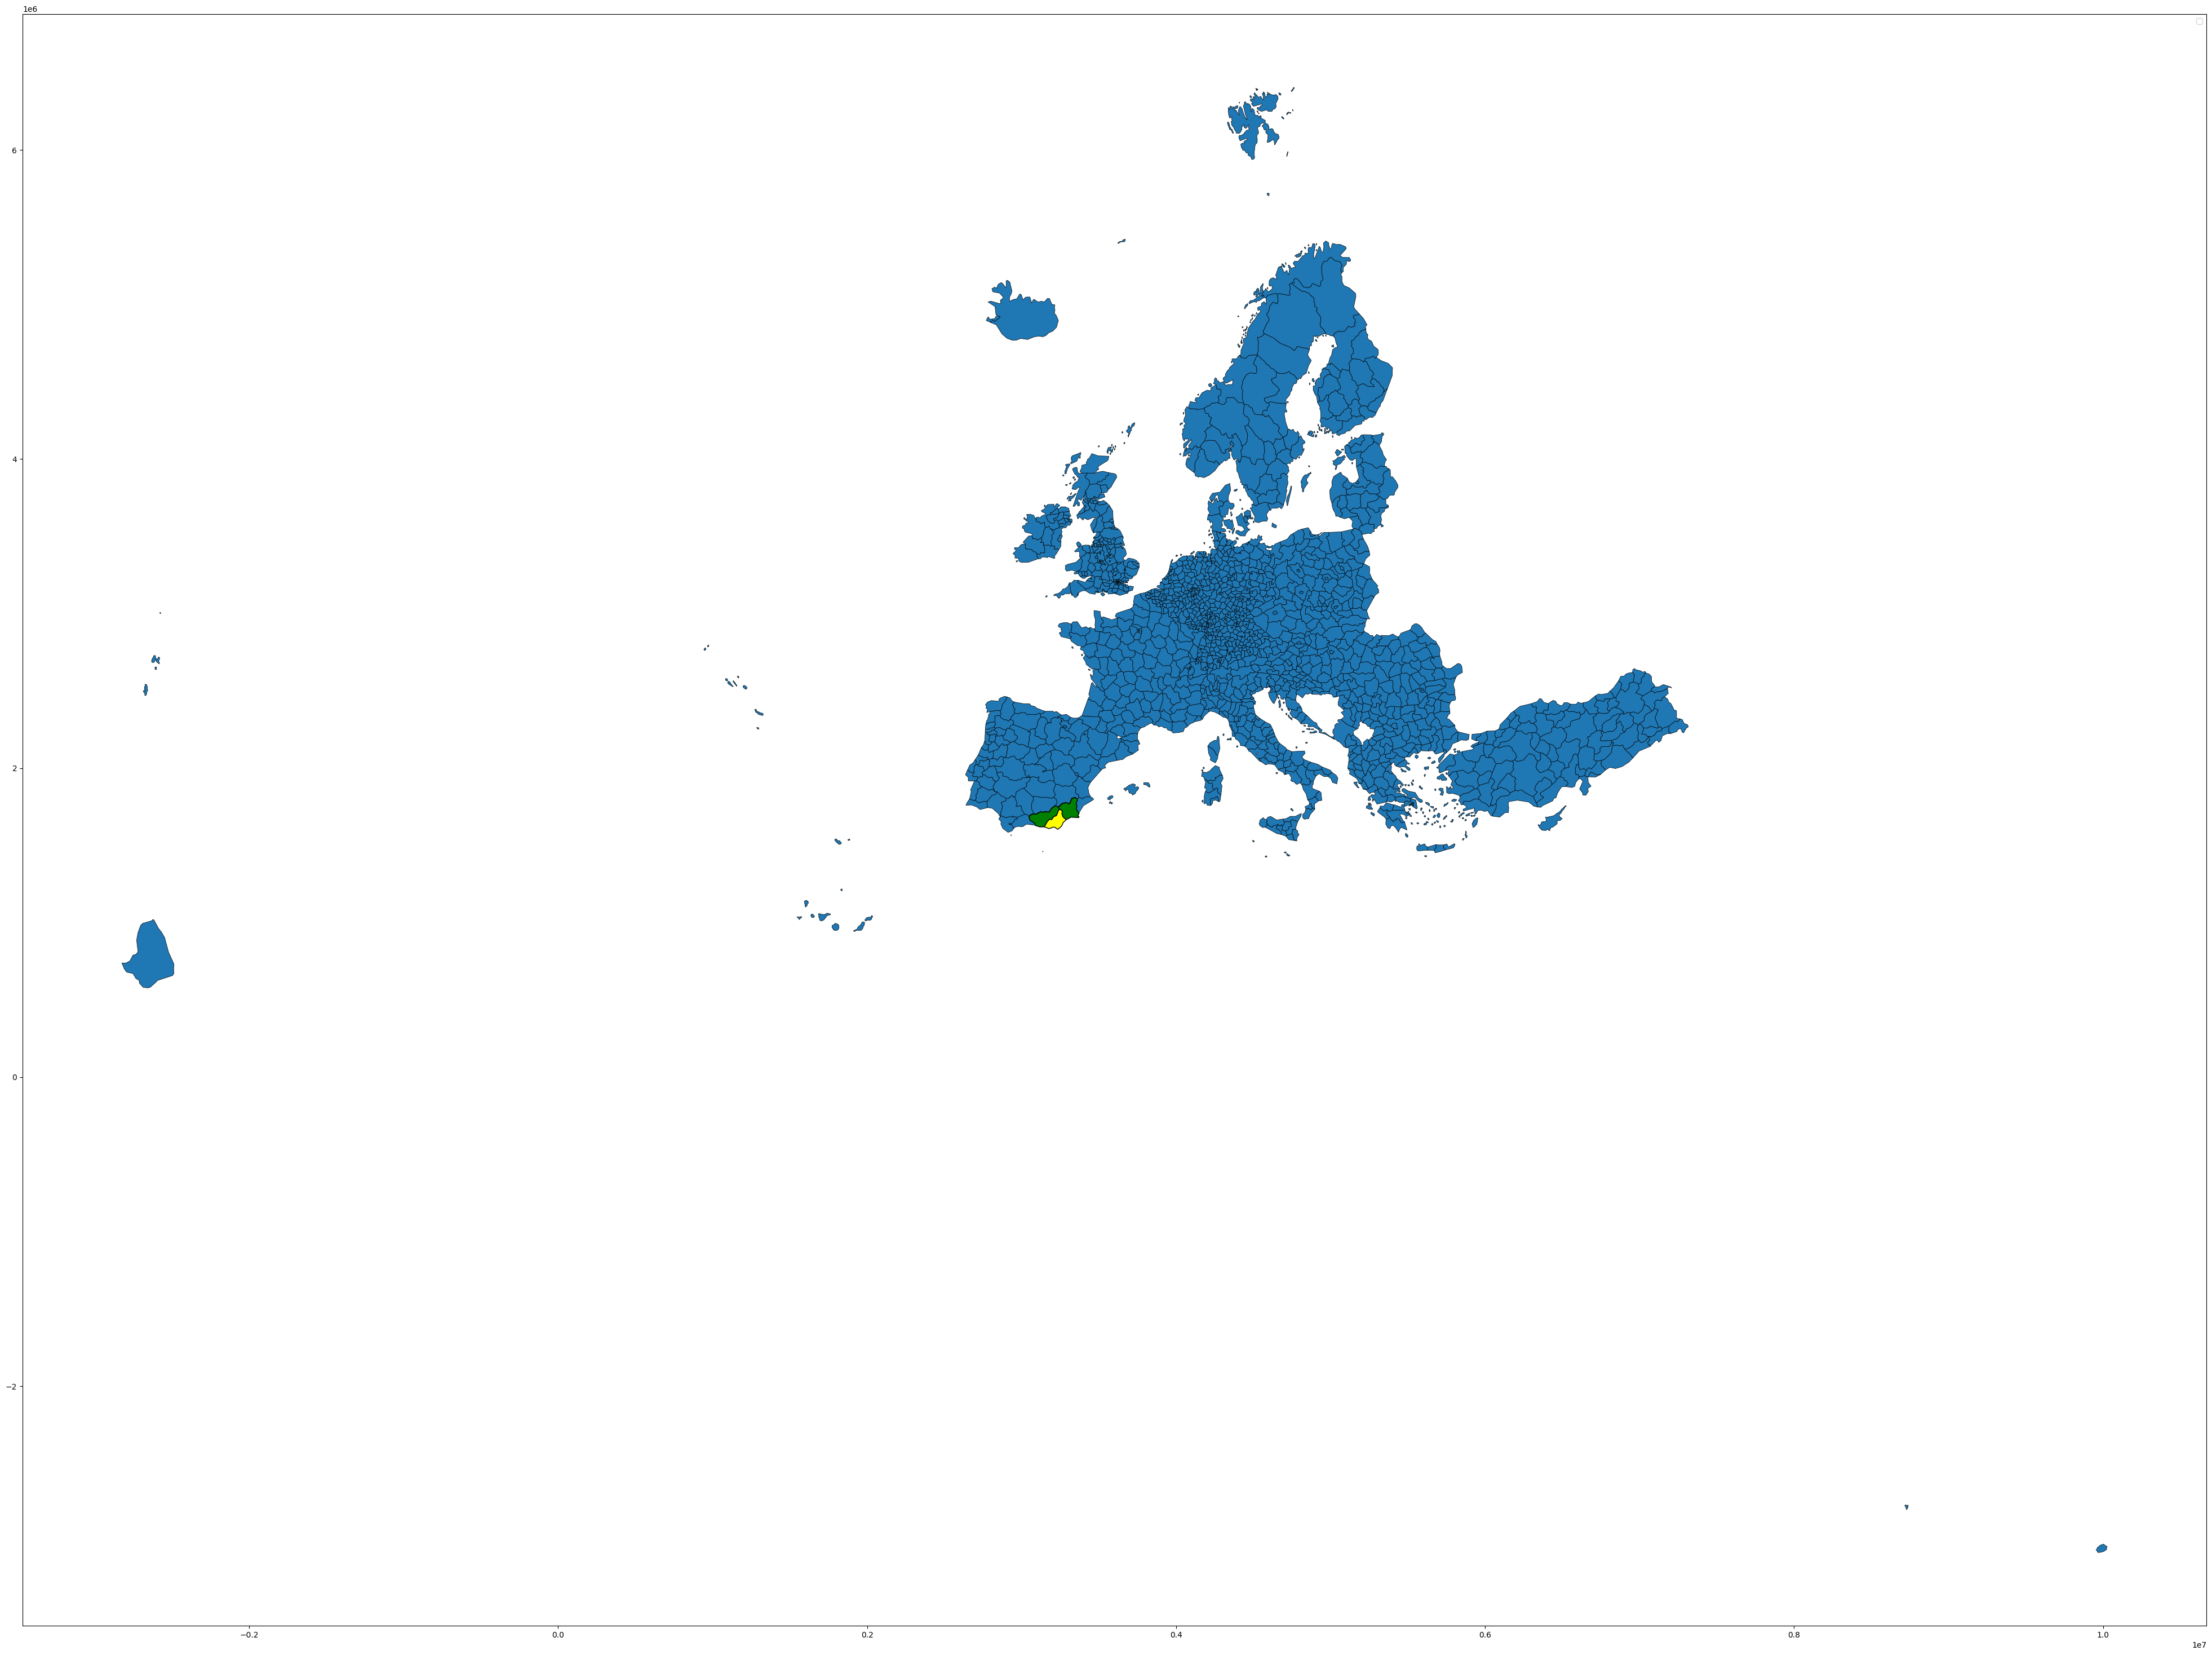

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame 'gdf' with 'NUTS' and 'geometry' columns
# Replace this with your actual GeoDataFrame
# Example data


# Create separate GeoDataFrames for each group of regions
highlighted_areas = {
    'ES611': gdf[gdf['NUTS_ID'] == 'ES611'],
    'ES620': gdf[gdf['NUTS_ID'] == 'ES620'],
    'ES614': gdf[gdf['NUTS_ID'] == 'ES614']
}

# Set the size of the figure
fig, ax = plt.subplots(figsize=(50, 50))

# Plot the entire map
gdf.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Plot each highlighted area with a different color
colors = {'ES611': 'yellow', 'ES620': 'green', 'ES614': 'green'}
for nuts_code, highlighted_area in highlighted_areas.items():
    highlighted_area.plot(ax=ax, color=colors[nuts_code], edgecolor='black', label=nuts_code)

# Add a legend
ax.legend()

plt.savefig('figures/NN_geo.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

